In [1]:
import numpy as np
import math
import torch
import torchvision
import matplotlib.pyplot as plt

In [4]:
T_d = np.array([[0.078, -0.494, 0.866, 1],[0.135,-0.855, -0.5, 2],[0.988, 0.156, 0, 2],[0,0,0,1]])
o_d = np.array([1,2,2])
L1 = 1
L2 = 1
L3 = 1
q = np.array([0,0,0])

In [5]:
#Generate Training Data
q_data = []
T_data = []
end_data = []
for i in range(1000):
    q = [np.random.uniform(-np.pi,np.pi),np.random.uniform(-np.pi,np.pi),np.random.uniform(-np.pi,np.pi)]
    line1 = [math.cos(q[0])*math.cos(q[1]+q[2]), -1*math.cos(q[0])*math.sin(q[1]+q[2]), math.sin(q[0]), L1*math.cos(q[0])+L2*math.cos(q[0])*math.cos(q[1])+L3*math.cos(q[0])*math.cos(q[1]+q[2])]
    line2 = [math.sin(q[0])*math.cos(q[1]+q[2]), -1*math.sin(q[0])*math.sin(q[1]+q[2]), -1*math.cos(q[0]), L1*math.sin(q[0])+L2*math.sin(q[0])*math.cos(q[1])+L3*math.sin(q[0])*math.cos(q[1]+q[2])]
    line3 = [math.sin(q[1]+q[2]), math.cos(q[1]+q[2]), 0, L2*math.sin(q[1])+L3*math.sin(q[1]+q[2])]
    line4 = [0,0,0,1]
    T_k = [line1, line2, line3, line4]
    end_pos = [math.cos(q[0])*(L1+L2*math.cos(q[1])+L3*math.cos(q[1]+q[2])),math.sin(q[0])*(L1+L2*math.cos(q[1])+L3*math.cos(q[1]+q[2])), L2*math.sin(q[1])+L3*math.sin(q[1]+q[2])]
    q_data.append(q)
    T_data.append(T_k)
    end_data.append(end_pos)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(3,50)
        self.lin2 = nn.Linear(50,3)
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x
net = Net()

In [7]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01)

In [8]:
def train(n_epochs):
    loss_over_time = []
    valid_loss_over_time = []
    for epoch in range(n_epochs):
        running_loss = 0.0
        net.train()
        for i in range(800):
            q = torch.tensor(q_data[i])
            end_pos = torch.tensor(end_data[i])
            optimizer.zero_grad()
            outputs = net(end_pos)
            loss = criterion(outputs, q)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        valid_loss = 0.0
        net.eval()
        for j in range(800,1000):
            q = torch.tensor(q_data[j])
            end_pos = torch.tensor(end_data[j])
            outputs = net(end_pos)
            loss = criterion(outputs, q)
            valid_loss += loss.item()
        valid_avg_loss = valid_loss/200
        valid_loss_over_time.append(valid_avg_loss)

        avg_loss = running_loss/800
        loss_over_time.append(avg_loss)
        print('Epoch: {}, Avg. Loss: {}'.format(epoch + 1, avg_loss))
    return loss_over_time, valid_loss_over_time

In [9]:
training_loss, validation_loss = train(200)

Epoch: 1, Avg. Loss: 2.8130609978875145
Epoch: 2, Avg. Loss: 2.713844125170726
Epoch: 3, Avg. Loss: 2.6866839083476224
Epoch: 4, Avg. Loss: 2.6682503057236318
Epoch: 5, Avg. Loss: 2.653263825814938
Epoch: 6, Avg. Loss: 2.6374753829382827
Epoch: 7, Avg. Loss: 2.622249970394187
Epoch: 8, Avg. Loss: 2.607549154555891
Epoch: 9, Avg. Loss: 2.592862441962352
Epoch: 10, Avg. Loss: 2.5786297402664786
Epoch: 11, Avg. Loss: 2.5654430259688525
Epoch: 12, Avg. Loss: 2.5530436068447306
Epoch: 13, Avg. Loss: 2.541771949829417
Epoch: 14, Avg. Loss: 2.531126021683449
Epoch: 15, Avg. Loss: 2.5229894536139907
Epoch: 16, Avg. Loss: 2.516042985817185
Epoch: 17, Avg. Loss: 2.509473268521833
Epoch: 18, Avg. Loss: 2.5024029180716023
Epoch: 19, Avg. Loss: 2.4960999623476527
Epoch: 20, Avg. Loss: 2.490573773232754
Epoch: 21, Avg. Loss: 2.4863121655693976
Epoch: 22, Avg. Loss: 2.480567561534117
Epoch: 23, Avg. Loss: 2.476618770251516
Epoch: 24, Avg. Loss: 2.4709723256796132
Epoch: 25, Avg. Loss: 2.4691810077289

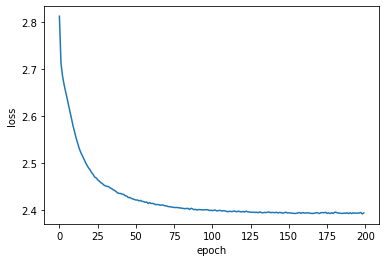

In [10]:
plt.plot(training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

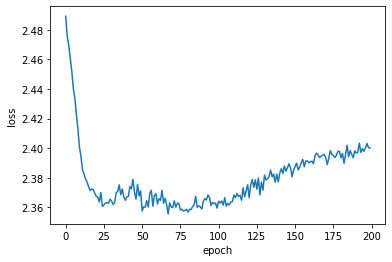

In [11]:
plt.plot(validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

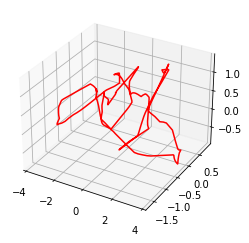

In [12]:
K = 500
traj = np.zeros((K,3))
traj[:,0] = 2*np.cos(np.linspace(0,2*np.pi,num=K))
traj[:,1] = 2*np.sin(np.linspace(0,2*np.pi,num=K))
traj[:,2] = np.sin(np.linspace(0,8*np.pi,num=K))
net.eval()

pred_traj = []
for i in range(K):
    x = float(traj[i][0])
    y = float(traj[i][1])
    z = float(traj[i][2])
    curr_traj = torch.tensor([x,y,z])
    output = net(curr_traj)
    pred_traj.append([float(output[0]),float(output[1]),float(output[2])])
pred_traj = np.array(pred_traj)
fig = plt.figure()
ax = plt.axes(projection ='3d')
 
ax.plot3D(pred_traj[:,0],pred_traj[:,1],pred_traj[:,2], "red")
plt.show()

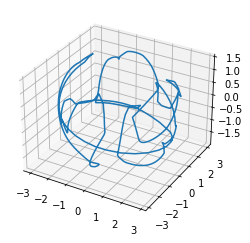

In [13]:
end_traj = []
for q in pred_traj:
    end_pos = [math.cos(q[0])*(L1+L2*math.cos(q[1])+L3*math.cos(q[1]+q[2])),math.sin(q[0])*(L1+L2*math.cos(q[1])+L3*math.cos(q[1]+q[2])), L2*math.sin(q[1])+L3*math.sin(q[1]+q[2])]
    end_traj.append(end_pos)

end_traj = np.array(end_traj)
fig = plt.figure()
ax = plt.axes(projection ='3d')
 
ax.plot3D(end_traj[:,0],end_traj[:,1],end_traj[:,2])
plt.show()